In [1]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
import glob as glob

2023-04-19 16:20:17.472268: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Feature selection
* Velocity is not the best
* dU improves the prediction
* Correlation of variables


In [2]:
def loadCombinedArray(cases,field):
    data = np.concatenate([np.load('../data/'+dataset+'/'+dataset+'_'+case+'_'+field + '.npy') for case in cases])
    return data


array([[<AxesSubplot:title={'center':'Ux'}>,
        <AxesSubplot:title={'center':'Uy'}>,
        <AxesSubplot:title={'center':'Uz'}>],
       [<AxesSubplot:title={'center':'dU11'}>,
        <AxesSubplot:title={'center':'dU12'}>,
        <AxesSubplot:title={'center':'dU21'}>],
       [<AxesSubplot:title={'center':'dU22'}>,
        <AxesSubplot:title={'center':'p'}>, <AxesSubplot:>]], dtype=object)

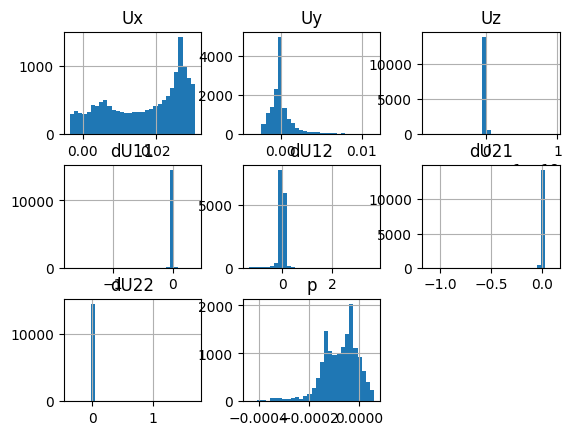

In [3]:
dataset = "kepsilon"
cases   = ["PHLL_case_1p0"]

x  = loadCombinedArray(cases,"Cx")
y  = loadCombinedArray(cases,"Cy")
z  = loadCombinedArray(cases,"Cz")
gU = loadCombinedArray(cases,"gradU")
dU11 = gU[:,0,0]
dU12 = gU[:,0,1]
dU21 = gU[:,1,0]
dU22 = gU[:,1,1]
Ux = loadCombinedArray(cases,"Ux")
Uy = loadCombinedArray(cases,"Uy")
Uz = loadCombinedArray(cases,"Uz")
p  = loadCombinedArray(cases,"p")


data_combined = np.column_stack((Ux,Uy,Uz,dU11,dU12,dU21,dU22,p))
df = pd.DataFrame(data=data_combined)
df.columns=["Ux","Uy","Uz","dU11","dU12","dU21","dU22","p"]
# print(df.describe())
df.hist(bins=30)

In [4]:

# fig, ax = plt.subplots(figsize=(6,2))

# ax.scatter(x,y,c="k",s=0.01)

In [5]:
# fig, ax = plt.subplots(4,figsize=(6,8),sharex=True)

# ax[0].tricontourf(x,y,Ux,levels=50,cmap="jet")
# ax[1].tricontourf(x,y,Uy,levels=50,cmap="jet")
# ax[2].tricontourf(x,y,Uz,levels=50,cmap="jet")
# ax[3].tricontourf(x,y,p, levels=50,cmap="jet")

In [6]:
df_features = df[["Ux","Uy","dU11","dU12","dU21","dU22"]]
df_target   = df["p"]

scaler_features = preprocessing.MinMaxScaler()
scaler_target   = preprocessing.MinMaxScaler()

df_features = pd.DataFrame(scaler_features.fit_transform(df_features),
                          columns=["Ux","Uy","dU11","dU12","dU21","dU22"])
df_target = pd.DataFrame(scaler_target.fit_transform(df_target.values.reshape(-1,1)),
                          columns=["p"])

In [7]:
# Building my NN
keras.backend.clear_session()

#Ux, Uy
input_layer = keras.layers.Input(shape=(6),name="input_layer")

#Hidden layers
hidden1     = keras.layers.Dense(20,name="Hidden1",kernel_initializer="lecun_normal",
                                activation="selu")(input_layer)
hidden2 = keras.layers.Dense(20,name='Hidden2', kernel_initializer="lecun_normal", activation = "selu")(hidden1)
hidden3 = keras.layers.Dense(20,name='Hidden3', kernel_initializer="lecun_normal", activation = "selu")(hidden2)
hidden4 = keras.layers.Dense(20,name='Hidden4', kernel_initializer="lecun_normal", activation = "selu")(hidden3)
hidden5 = keras.layers.Dense(20,name='Hidden5', kernel_initializer="lecun_normal", activation = "selu")(hidden4)


output_layer = keras.layers.Dense(1,name="output_layer")(hidden5)

model=keras.Model(inputs=[input_layer], outputs=[output_layer])
model.summary()
# 
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(optimizer,loss="mse",metrics=["mae","mse"])
# 
history = model.fit([df_features],df_target,
                    epochs=200,
                    verbose= 1,
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 6)]               0         
                                                                 
 Hidden1 (Dense)             (None, 20)                140       
                                                                 
 Hidden2 (Dense)             (None, 20)                420       
                                                                 
 Hidden3 (Dense)             (None, 20)                420       
                                                                 
 Hidden4 (Dense)             (None, 20)                420       
                                                                 
 Hidden5 (Dense)             (None, 20)                420       
                                                                 
 output_layer (Dense)        (None, 1)                 21    

461/461 [==============================] - 1s 2ms/step - loss: 0.0027 - mae: 0.0356 - mse: 0.0027
Epoch 63/200
461/461 [==============================] - 1s 2ms/step - loss: 0.0025 - mae: 0.0344 - mse: 0.0025
Epoch 64/200
461/461 [==============================] - 1s 2ms/step - loss: 0.0024 - mae: 0.0334 - mse: 0.0024
Epoch 65/200
461/461 [==============================] - 1s 2ms/step - loss: 0.0025 - mae: 0.0334 - mse: 0.0025
Epoch 66/200
461/461 [==============================] - 1s 2ms/step - loss: 0.0023 - mae: 0.0326 - mse: 0.0023
Epoch 67/200
461/461 [==============================] - 1s 2ms/step - loss: 0.0028 - mae: 0.0358 - mse: 0.0028
Epoch 68/200
461/461 [==============================] - 1s 2ms/step - loss: 0.0028 - mae: 0.0358 - mse: 0.0028
Epoch 69/200
461/461 [==============================] - 1s 2ms/step - loss: 0.0032 - mae: 0.0377 - mse: 0.0032
Epoch 70/200
461/461 [==============================] - 1s 2ms/step - loss: 0.0033 - mae: 0.0388 - mse: 0.0033
Epoch 71/200
4

461/461 [==============================] - 1s 2ms/step - loss: 0.0031 - mae: 0.0360 - mse: 0.0031
Epoch 136/200
461/461 [==============================] - 1s 2ms/step - loss: 0.0025 - mae: 0.0317 - mse: 0.0025
Epoch 137/200
461/461 [==============================] - 1s 2ms/step - loss: 0.0031 - mae: 0.0366 - mse: 0.0031
Epoch 138/200
461/461 [==============================] - 1s 2ms/step - loss: 0.0027 - mae: 0.0347 - mse: 0.0027
Epoch 139/200
461/461 [==============================] - 1s 2ms/step - loss: 0.0027 - mae: 0.0338 - mse: 0.0027
Epoch 140/200
461/461 [==============================] - 1s 2ms/step - loss: 0.0021 - mae: 0.0306 - mse: 0.0021
Epoch 141/200
461/461 [==============================] - 1s 2ms/step - loss: 0.0037 - mae: 0.0389 - mse: 0.0037
Epoch 142/200
461/461 [==============================] - 1s 2ms/step - loss: 0.0018 - mae: 0.0285 - mse: 0.0018
Epoch 143/200
461/461 [==============================] - 1s 2ms/step - loss: 0.0043 - mae: 0.0439 - mse: 0.0043
Epoch 

In [8]:
predictions = model.predict(df_features).reshape(len(df_features))
truth = df_target['p']

# fig = plt.figure(figsize=(12,12))
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)

# ax1.tricontourf(x,y,predictions,levels=50,vmin=0,vmax=1)
# ax1.set_aspect(1)
# ax1.set_title('Predictions')
# ax2.tricontourf(x,y,truth,levels=50,vmin=0,vmax=1)
# ax2.set_aspect(1)
# ax2.set_title('Truth')

461/461 [==============================] - 1s 1ms/step


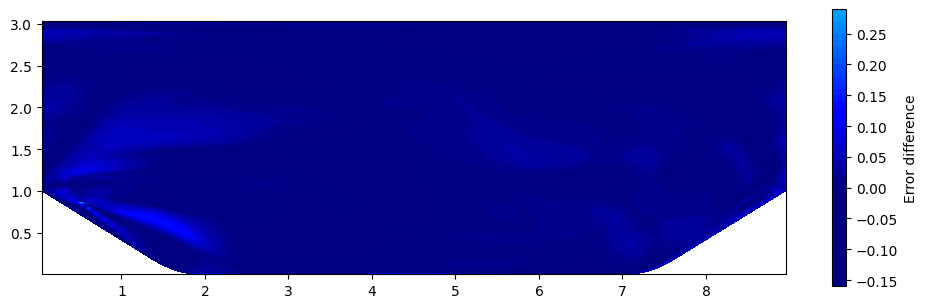

In [9]:
#Error
# calculate error for each point


fig, ax = plt.subplots(figsize=(12,12))

contour = ax.tricontourf(x,y,predictions-truth,levels=50,vmin=0,vmax=1,cmap="jet")
ax.set_aspect(1)

cbar = plt.colorbar(contour, ax=ax,shrink=0.3)
cbar.set_label('Error difference')

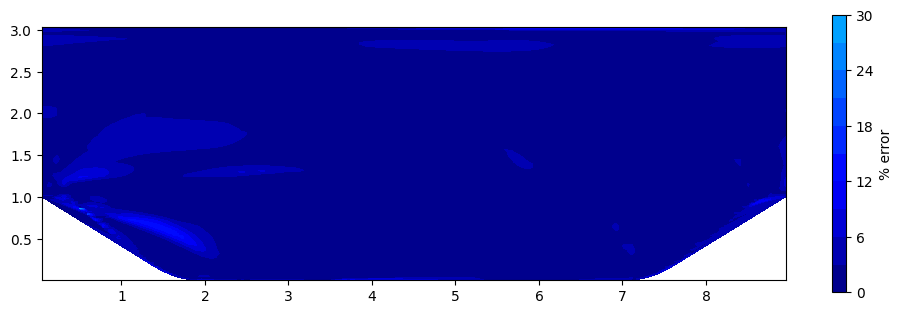

In [10]:
#Error
# calculate error for each point


fig, ax = plt.subplots(figsize=(12,12))

contour = ax.tricontourf(x,y,abs(predictions-truth)/truth.max()*100,
                         levels=10,
                         vmin=0,
                         vmax=100,
                         cmap="jet")
ax.set_aspect(1)

cbar = plt.colorbar(contour, ax=ax,shrink=0.3)
cbar.set_label('% error')

In [11]:
abs(predictions-truth).mean()*100

1.5694500722129616

In [12]:
abs(predictions-truth).max()*100

28.753786659220864